# Semantic Segmentation 

## Analyzing Arterial Blood Pressure Data with FLUSS and FLOSS

This example utilizes the main takeways from the [Matrix Profile VIII](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf) research paper. For proper context, we highly recommend that you read the paper first but know that our implementations follow this paper closely.

According to the aforementioned publication, "one of the most basic analyses one can perform on [increasing amounts of time series data being captured] is to segment it into homogeneous regions." In other words, wouldn't it be nice if you could take your long time series data and be able to segment or chop it up into `k` regions (where `k` is small) and with the ultimate goal of presenting only `k` short representative patterns to a human (or machine) annotator in order to produce labels for the entire dataset. These segmented regions are also known as "regimes". Additionally, as an exploratory tool, one might uncover new actionable insights in the data that was previously undiscovered. Fast low-cost unipotent semantic segmentation (FLUSS) is an algorithm that produces something called an "arc curve" which annotates the raw time series with information about the likelihood of a regime change. Fast low-cost online semantic segmentation (FLOSS) is a variation of FLUSS that, according to the original paper, is domain agnostic, offers streaming capabilities with potential for actionable real-time intervention, and is suitable for real world data (i.e., does not assume that every region of the data belongs to a well-defined semantic segment).

To demonstrate the API and underlying principles, we will be looking at arterial blood pressure (ABP) data from from a healthy volunteer restingon a medical tilt table and will be seeing if we can detect when the table is tilted from a horizontal position to a vertical position. This is the same data that is presented throughout the original paper (above).

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
import urllib
import ssl
import io
import os

## Retrieve the Data

In [2]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://sites.google.com/site/timeserieschain/home/TiltABP_210_25000.txt'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
df = pd.read_csv(data, header=None)
df = df.reset_index().rename({'index': 'time', 0: 'abp'}, axis='columns')
df.head()

time     abp
0     0  6832.0
1     1  6928.0
2     2  6968.0
3     3  6992.0
4     4  6980.0

## Visualizing the Raw Data

In [3]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size

change_plot_size(20, 6, plt)

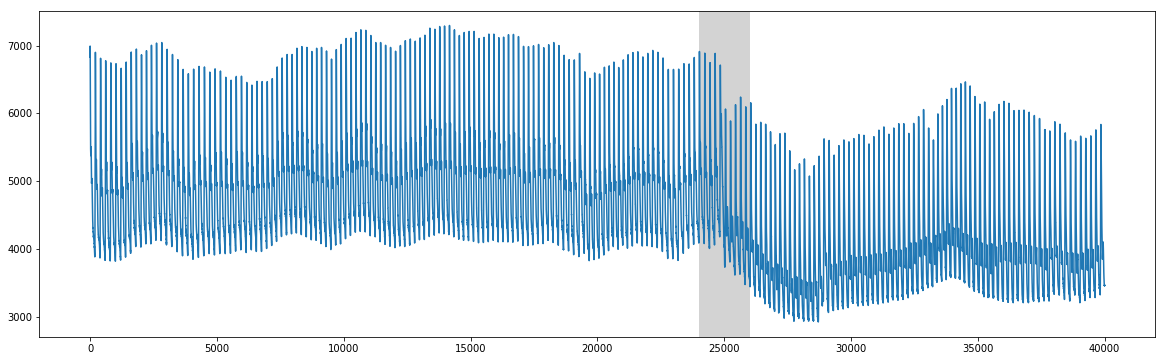

In [4]:
plt.plot(df['time'], df['abp'])
rect = Rectangle((24000,2400),2000,6000,facecolor='lightgrey')
plt.gca().add_patch(rect)

We can clearly see that there is a change around `time=25000` that corresponds to when the table was tilted upright. 

## FLUSS

Instead of using the full dataset, let's zoom in and analyze the 2,500 data points directly before and after `x=25000` (see Figure 5 in the paper). 

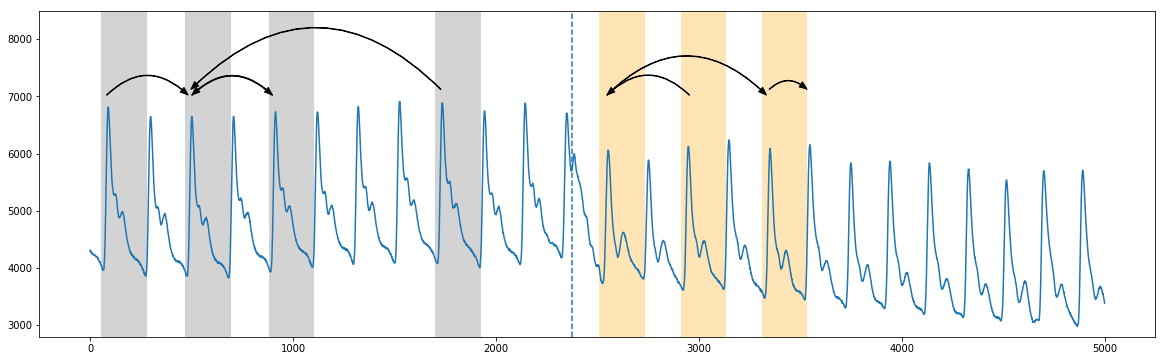

In [5]:
start = 25000 - 2500
stop = 25000 + 2500
abp = df.iloc[start:stop, 1]
plt.plot(range(abp.shape[0]), abp)
plt.ylim(2800, 8500)
plt.axvline(x=2373, linestyle="dashed")

style="Simple, tail_width=0.5, head_width=6, head_length=8"
kw = dict(arrowstyle=style, color="k")

# regime 1
rect = Rectangle((55,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((470,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((880,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((1700,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((75, 7000), (490, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((495, 7000), (905, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((905, 7000), (495, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((1735, 7100), (490, 7100), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)

# regime 2
rect = Rectangle((2510,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((2910,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((3310,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((2540, 7000), (3340, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((2960, 7000), (2540, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((3340, 7100), (3540, 7100), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)

Roughly, in the truncated plot above, we see that the segmentation between the two regimes occurs around `time=2373` (vertical dotted line) where the patterns from the first regime (grey) don't cross over to the second regime (orange) (see Figure 2 in the original paper). And so the "arc curve" is calculated by sliding along the time series and simply counting the number of times other patterns haved "crossed over" that specific time point (i.e., "arcs"). Essentially, this information can extracted by looking at the matrix profile indices (which tells you where along the time series your nearest neighbor is). And so, we'd expect the arc counts to be high where repeated patterns are near each other and low where there are no crossing arcs.

Before we compute the "arc curve", we'll need to first compute the standard matrix profile and we can approximately see that the window size is about 210 data points (thanks to knowledge of the subject matter/domain expert).

In [6]:
m = 210
mp = stumpy.stump(abp, m=m)

Now, to compute the "arc curve" and determine the location of the regime change, we can directly call the `fluss` function. However, note that `fluss` requires the following inputs:

1. the matrix profile indices `mp[:, 1]` (not the matrix profile distances)
2. an appropriate subsequence length, `L` (for convenience, we'll just choose it to be equal to the window size, `m=210`)
3. the number of regimes to search for (2 regions in this case)
4. an exclusion factor to nullify the beginning and end of the arc curve (anywhere between 1-5 is reasonable according to the paper)

In [7]:
L = 210
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

Notice that `fluss` actually returns something called the "corrected arc curve" (CAC), which normalizes the fact that there are typically less arcs crossing over a time point near the beginning and end of the time series and more potential for cross overs near the middle of the time series. Additionally, `fluss` returns the regimes or location(s) of the dotted line(s). Let's plot our original time series (top) along with the corrected arc curve (orange) and the single regime (vertical dotted line).

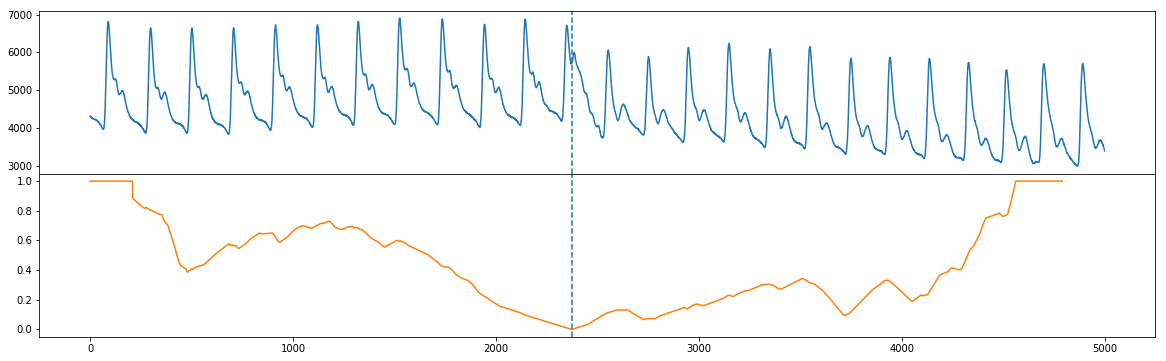

In [8]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

## FLOSS

Unlike FLUSS, FLOSSS is concerned with streaming data, and so it calculates a modified version of the corrected arc curve (CAC) that is strictly one-directional (CAC_1D) rather than bidirectional. That is, instead of expecting cross overs to equally likely from both directions, we expect more cross overs to point toward the future (and less to point toward the past). So, we can manually compute the `CAC_1D`

In [9]:
cac_1d = stumpy._cac(mp[:, 3], L, bidirectional=False, excl_factor=1)  # This is for demo purposes only. Use floss() below!

and compare the `CAC_1D` (blue) with the bidirectional `CAC` (orange) and we see that the global minimum are approximately in the same place (see Figure 10 in the original paper). 

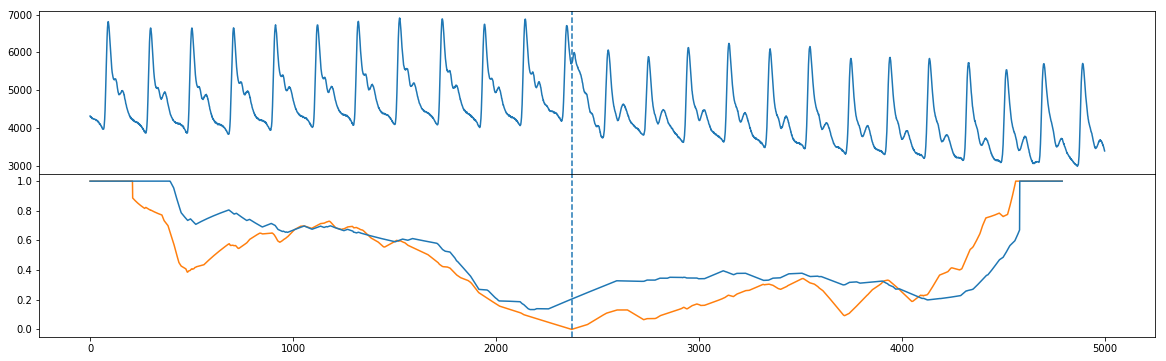

In [11]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)

## Streaming Data with FLOSS

Instead of manually computing `CAC_1D` like we did above on streaming data, we can actually call the `floss` function directly which returns back a Python generator. To demonstrate the use of `floss`, let's take some `old_data` and compute the matrix profile indices for it like we did above:

In [12]:
old_data = df.iloc[20000:20000+5000, 1].values  # This is well before the regime change has occurred

mp = stumpy.stump(old_data, m=m)

Now, we could do what we did early and compute the bidirectional corrected arc curve but we'd like to how the arc curve changes as a result of adding new data points. So, let's define some new data that is to be streamed in:

In [13]:
add_data = df.iloc[25000:25000+5000, 1].values

Finally, we call the `floss` function and pass in:

1. the matrix profile generated from the `old_data` (only the indices are used)
2. the old data used to generate the matrix profile in 1.
3. the new data that you'd like to compute the `CAC_1D` for
4. the matrix profile window size, `m=210`
5. the subsequence length, `L=210`
6. the exclusion factor
7. an optional `skip` parameter for skipping frames so that our sliding window returns every 100th window

In [14]:
floss_gen = stumpy.floss(mp, old_data, add_data, m=m, L=L, excl_factor=1, skip=99)

Note that as you iterate over the `floss` generator, each iteration will slide your window over by one data point and yield:

1. an updated `CAC_1D`
2. an updated matrix profile
3. the sliding window of data used to produce the `CAC_1D` (this should be the same size as the length of the `old_data`)

Below, you can see an animation that iterates over the output yielded by the FLOSS generator. For reference, we've also plotted the `CAC_1D` (orange) that we manually generated above for the stationary data. You'll see that halfway through the animation, the regime change occurs and the updated `CAC_1D` (blue) will be perfectly aligned with the orange curve.

In [15]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_xlim((0, mp.shape[0]))
axs[0].set_ylim((-0.1, max(np.max(old_data), np.max(add_data))))
axs[1].set_xlim((0, mp.shape[0]))
axs[1].set_ylim((-0.1, 1.1))

lines = []
for ax in axs:
    line, = ax.plot([], [], lw=2)
    lines.append(line)
line, = axs[1].plot([], [], lw=2)
lines.append(line)
    
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(window):
    cac_out, mp_out, data_out = window  # The generator returns the updated cac_1d, matrix profile, and data 
    for line, data in zip(lines, [data_out, cac_out, cac_1d]):
        line.set_data(np.arange(data.shape[0]), data)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=floss_gen, interval=100, 
                               blit=True)

anim_out = anim.to_jshtml()
plt.close()  # Prevents duplicate image from displaying
os.remove("None0000000.png")  # Delete rogue temp file 

HTML(anim_out)

## Summary

And that's it! You've just learned the basics of how to identify segments within your data using the matrix profile indices and leveraging `fluss` and `floss`.

## Resources
​
[Matrix Profile VIII](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf)